Import 

In [1]:
import glob
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report

We load the data with glob

In [2]:
lst_fire_img = glob.glob('/kaggle/input/fire-dataset/fire_dataset/fire_images/*.png')
lst_non_fire_img = glob.glob('/kaggle/input/fire-dataset/fire_dataset/non_fire_images/*.png')

In [3]:
lst_non_fire_img

['/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.154.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.115.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.59.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.58.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.166.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.142.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.44.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.11.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.19.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.169.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.242.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.29.png',
 '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.182.png',
 '/ka

In [4]:
print('Number of images with fire : {}'.format(len(lst_fire_img)))
print('Number of images with fire : {}'.format(len(lst_non_fire_img)))

Number of images with fire : 755
Number of images with fire : 244


We plot 20 images to see how are the data

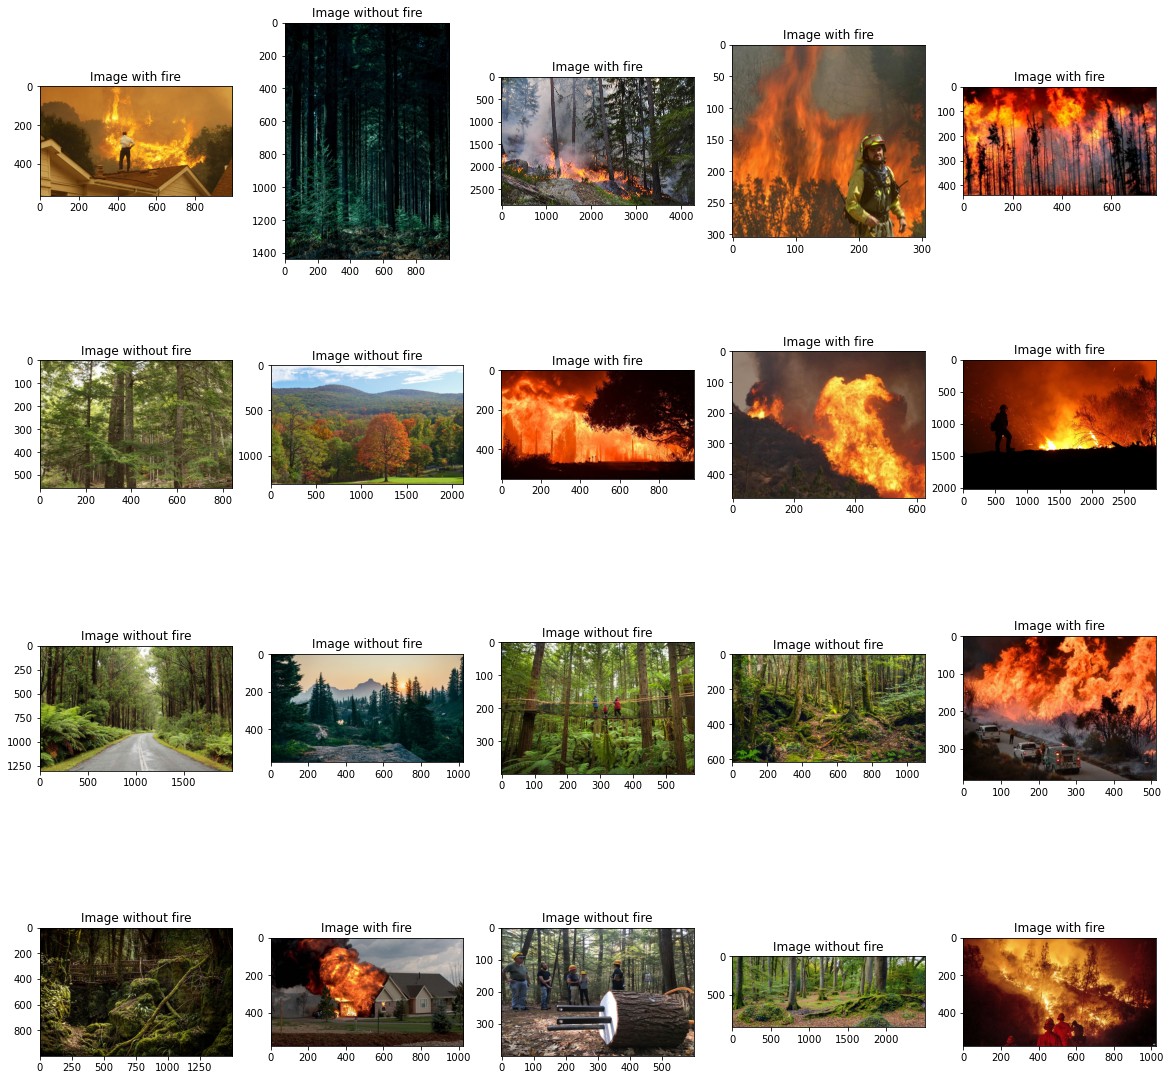

In [5]:
lst_images_random = random.sample(lst_fire_img,10) + random.sample(lst_non_fire_img,10)
random.shuffle(lst_images_random)

plt.figure(figsize = (20,20))

for i in range(len(lst_images_random)):
    
    plt.subplot(4,5,i+1)


    if "non_fire" in lst_images_random[i]:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title('Image without fire')

    else:
        img = cv2.imread(lst_images_random[i])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        plt.imshow(img,cmap = 'gray')
        plt.title("Image with fire")



plt.show()

We create a dataframe with filepath images and label (1 = fire , 0 = without fire)

In [6]:
lst_fire = []
for x in lst_fire_img:
  lst_fire.append([x,1])
lst_nn_fire = []
for x in lst_non_fire_img:
  lst_nn_fire.append([x,0])
lst_complete = lst_fire + lst_nn_fire
random.shuffle(lst_complete)

In [7]:
df = pd.DataFrame(lst_complete,columns = ['files','target'])
df.head(10)

,files,target
0,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
1,/kaggle/input/fire-dataset/fire_dataset/non_fi...,0
2,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
3,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
4,/kaggle/input/fire-dataset/fire_dataset/non_fi...,0
5,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
6,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
7,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
8,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1
9,/kaggle/input/fire-dataset/fire_dataset/fire_i...,1


We have a problem with image 189 in non_fire_images so we drop it

In [8]:
filepath_img = '/kaggle/input/fire-dataset/fire_dataset/non_fire_images/non_fire.189.png'
df = df.loc[~(df.loc[:,'files'] == filepath_img),:]

In [9]:
df.shape

(998, 2)

We can see that the dataset is unbalanced, but we don't use ImageDataGenerator because the result are pretty good despite this

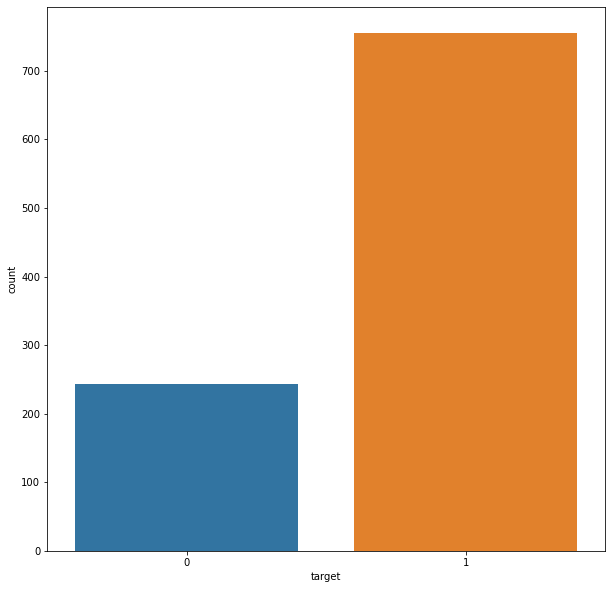

In [10]:
plt.figure(figsize = (10,10))


sns.countplot(x = "target",data = df)

plt.show()

We preprocess all the images 

In [11]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(196,196))  # resize
  img = img / 255 #scale
  return img 

We create numpy array X and y . X are 998 images with (196,196,3) shape, y the target is (998,) shape

In [12]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [13]:
X, y = create_format_dataset(df)

In [14]:
X.shape,y.shape

((998, 196, 196, 3), (998,))

we split the data in train and test 

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,stratify = y)

In [16]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((698, 196, 196, 3), (300, 196, 196, 3), (698,), (300,))

In [17]:
model = Sequential()

model.add(Conv2D(128,(2,2),input_shape = (196,196,3),activation='relu'))
model.add(Conv2D(64,(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 195, 128)     1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 194, 64)      32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9

In [19]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 30,batch_size = 32,callbacks = callbacks)

Epoch 1/30
22/22 [==============================] - 111s 5s/step - loss: 1.2149 - accuracy: 0.7249 - val_loss: 0.1795 - val_accuracy: 0.9433
Epoch 2/30
22/22 [==============================] - 112s 5s/step - loss: 0.1301 - accuracy: 0.9484 - val_loss: 0.1411 - val_accuracy: 0.9433
Epoch 3/30
22/22 [==============================] - 111s 5s/step - loss: 0.2130 - accuracy: 0.9226 - val_loss: 0.1684 - val_accuracy: 0.9133
Epoch 4/30
22/22 [==============================] - 112s 5s/step - loss: 0.1190 - accuracy: 0.9456 - val_loss: 0.1834 - val_accuracy: 0.9300
Epoch 5/30
22/22 [==============================] - 110s 5s/step - loss: 0.1210 - accuracy: 0.9470 - val_loss: 0.0873 - val_accuracy: 0.9700
Epoch 6/30
22/22 [==============================] - 111s 5s/step - loss: 0.0891 - accuracy: 0.9628 - val_loss: 0.0857 - val_accuracy: 0.9667
Epoch 7/30
22/22 [==============================] - 113s 5s/step - loss: 0.0671 - accuracy: 0.9756 - val_loss: 0.0756 - val_accuracy: 0.9733
Epoch 8/30
22

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_pred = y_pred.reshape(-1)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')

In [22]:
y_pred

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

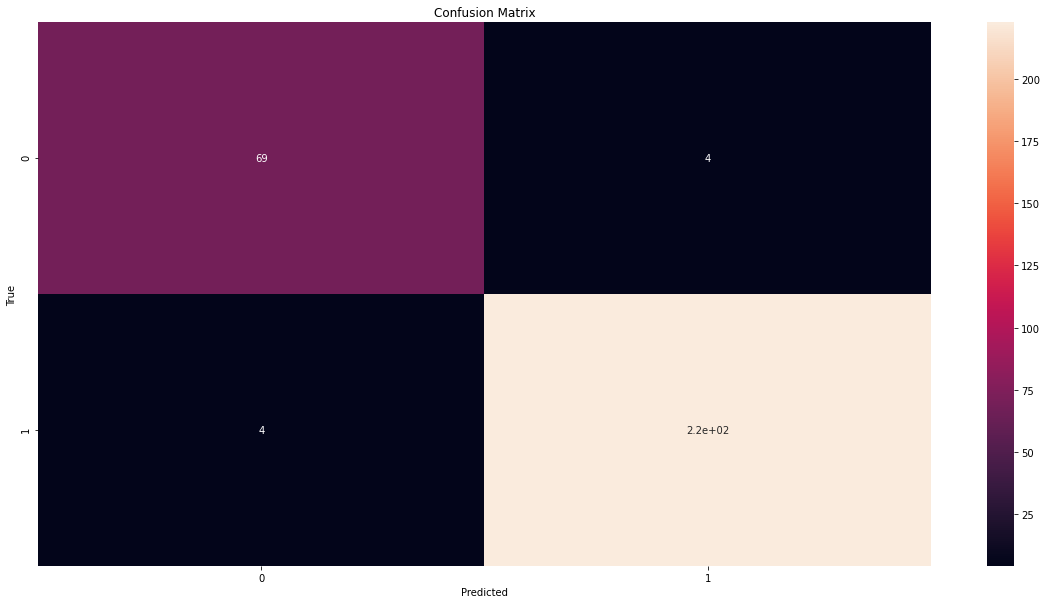

In [23]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y_test,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [24]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        73
           1       0.98      0.98      0.98       227

    accuracy                           0.97       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.97      0.97      0.97       300

